In [1]:
# Base Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')
import missingno as msno

# Hypothesis Tests
# Normality Test
from scipy.stats import shapiro

# Variance Homogeneity Test
from scipy.stats import levene

# Test
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy import stats

import pylab

# Configuration
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
        
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

/kaggle/input/mobile-games-ab-testing/cookie_cats.csv


In [2]:
df = pd.read_csv('../input/mobile-games-ab-testing/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the test group (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first week after installation
<li><code>retention_1</code> - did the player come back and play 1 day after installing?</li>
<li><code>retention_7</code> - did the player come back and play 7 days after installing?</li>
</ul>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
df.sum_gamerounds.describe()

count   90189.0000
mean       51.8725
std       195.0509
min         0.0000
25%         5.0000
50%        16.0000
75%        51.0000
max     49854.0000
Name: sum_gamerounds, dtype: float64

## Missing Values

In [5]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

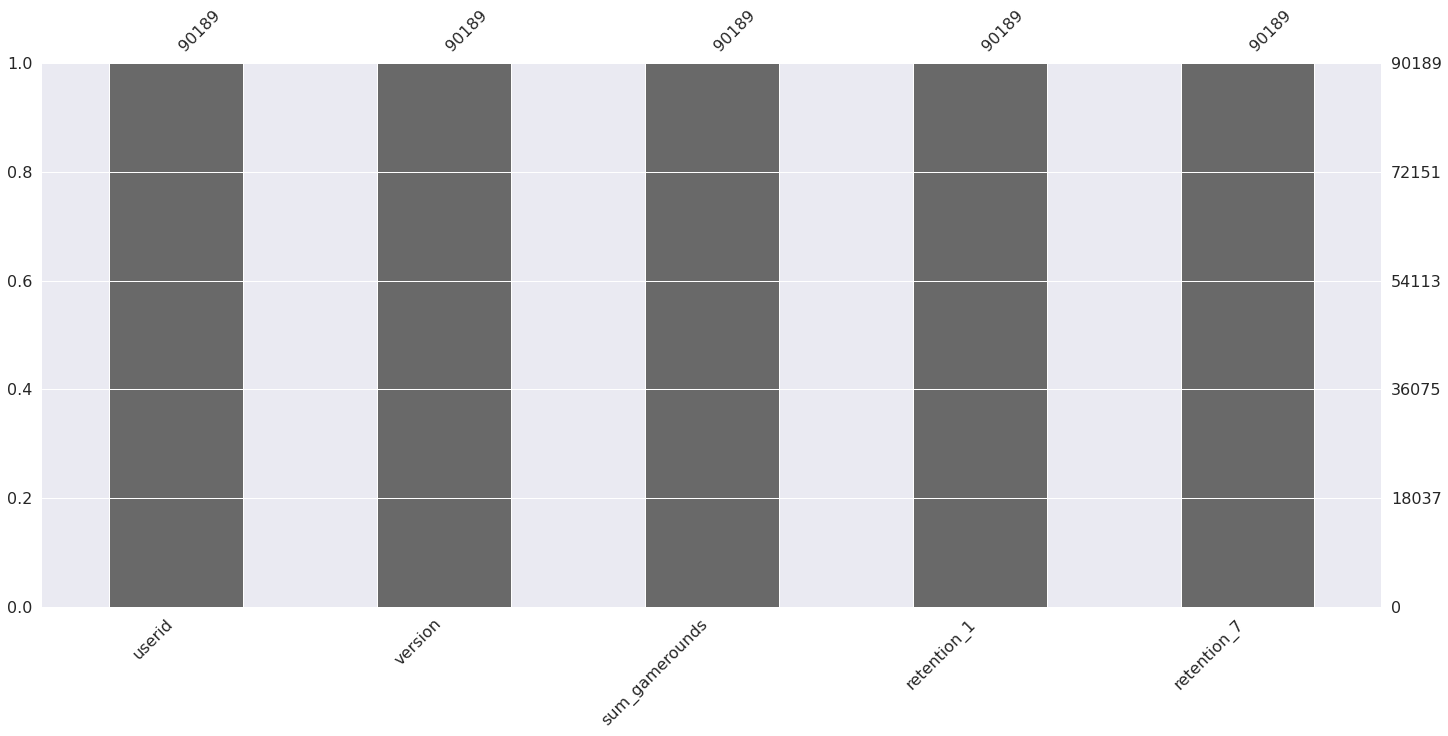

In [6]:
msno.bar(df)
plt.show()

# Data Visualization

gate_40    45489
gate_30    44700
Name: version, dtype: int64


<AxesSubplot:xlabel='version', ylabel='count'>

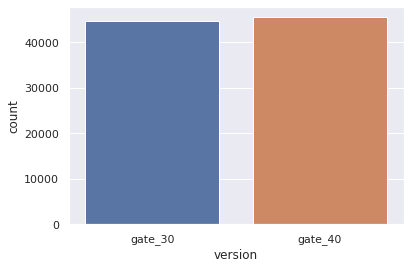

In [7]:
# version
print(df.version.value_counts())
sns.countplot(data=df,x='version')

False    50036
True     40153
Name: retention_1, dtype: int64


<AxesSubplot:xlabel='retention_1', ylabel='count'>

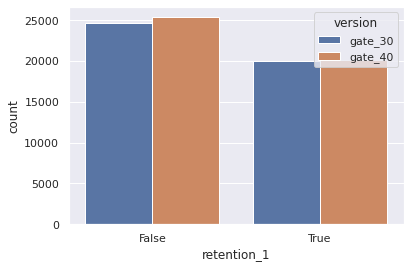

In [8]:
# retention vs version
print(df.retention_1.value_counts())
sns.countplot(data=df,x='retention_1', hue='version')

## **Data Analysis**

In [9]:
# Sum_gamerounds
df.describe([0.01,0.10,0.50,0.80, 0.90, 0.95, 0.99])[['sum_gamerounds']].T

,count,mean,std,min,1%,10%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [10]:
# Number of Unique Users
print(f' Unique User: {df.userid.nunique()}')
print(f' Total Userid: {df.shape[0]}')

if df.userid.nunique() == df.shape[0]:
    print(' Result: All users are different.')
else:
    print(' Result: There are the same values.')

 Unique User: 90189
 Total Userid: 90189
 Result: All users are different.


In [11]:
df.loc[df['version'] == 'gate_30','version'] = 'versionA'
df.loc[df['version'] == 'gate_40','version'] = 'versionB'

In [12]:
df.loc[df['retention_1'] == False,'retention_1'] = 0
df.loc[df['retention_1'] == True,'retention_1'] = 1

In [13]:
df.loc[df['retention_7'] == False,'retention_7'] = 0
df.loc[df['retention_7'] == True,'retention_7'] = 1

In [14]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,versionA,3,0,0
1,337,versionA,38,1,0
2,377,versionB,165,1,0
3,483,versionB,1,0,0
4,488,versionB,179,1,1


In [15]:
df.groupby('version').sum_gamerounds.agg(['count','median','mean','std','max']).T

version,versionA,versionB
count,44700.0000,45489.0000
median,17.0000,16.0000
mean,52.4563,51.2988
std,256.7164,103.2944
max,49854.0000,2640.0000


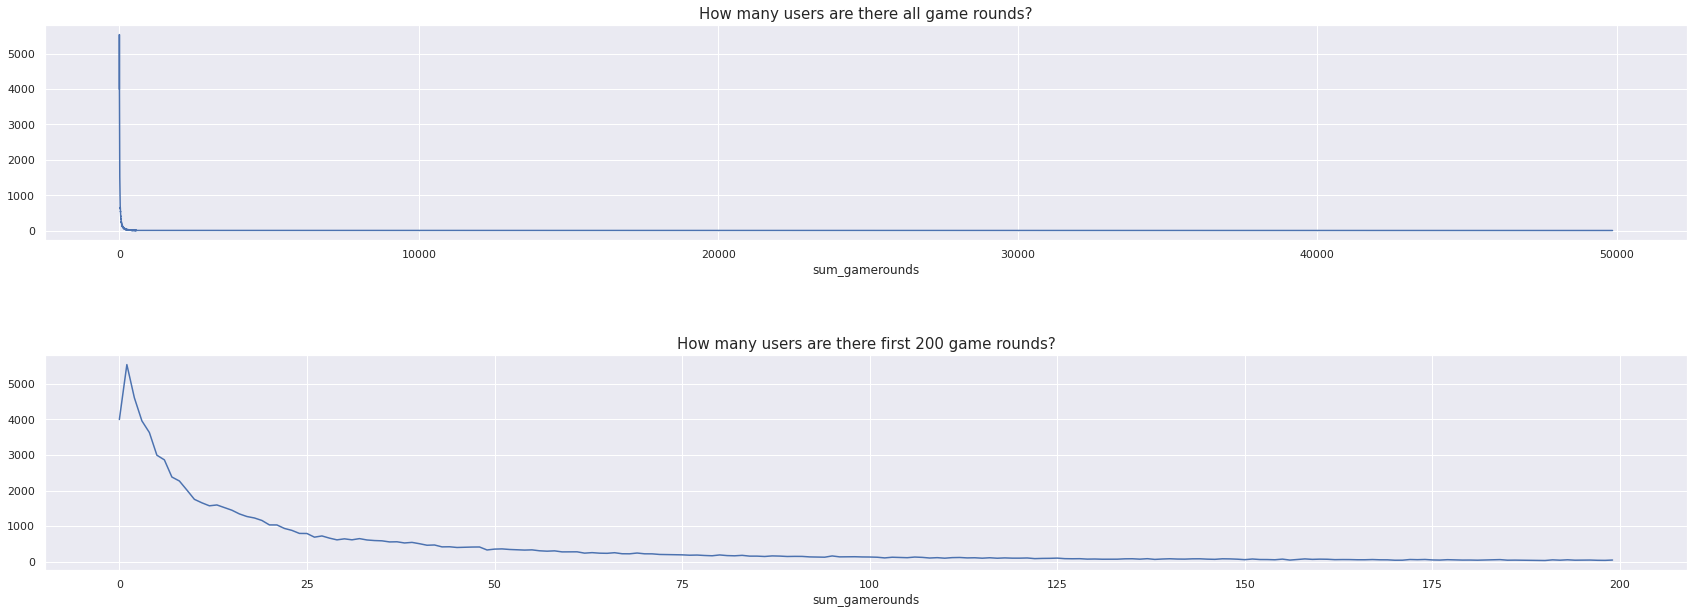

In [16]:
fig, axes = plt.subplots(2, 1, figsize = (25,10))
df.groupby("sum_gamerounds").userid.count().plot(ax = axes[0])
df.groupby("sum_gamerounds").userid.count()[:200].plot(ax = axes[1])
axes[0].set_title("How many users are there all game rounds?", fontsize = 15)
axes[1].set_title("How many users are there first 200 game rounds?", fontsize = 15)
plt.tight_layout(pad=5);

**Retention variables gives us player retention details.**

<li><code>retention_1</code> - did the player come back and play 1 day after installing?</li>
<li><code>retention_7</code> - did the player come back and play 7 days after installing?</li>

In [17]:
# Retention Problem
pd.DataFrame({"RET1_COUNT": df["retention_1"].value_counts(),
              "RET7_COUNT": df["retention_7"].value_counts(),
              "RET1_RATIO": df["retention_1"].value_counts() / len(df),
              "RET7_RATIO": df["retention_7"].value_counts() / len(df)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
0,50036,73408,0.5548,0.8139
1,40153,16781,0.4452,0.1861


In [18]:
df.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median    mean      std    max
version  retention_1                                       
versionA 0            24666       6 18.3796 319.4232  49854
         1            20034      48 94.4117 135.0377   2961
versionB 0            25370       6 16.3404  35.9258   1241
         1            20119      49 95.3812 137.8873   2640

In [19]:
df.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median     mean      std    max
version  retention_7                                        
versionA 0            36198      11  25.7965  43.3162    981
         1             8502     105 165.9625 568.0006  49854
versionB 0            37210      11  25.8564  44.4061   2640
         1             8279     111 165.6498 183.7925   2294

In [20]:
df["NewRetention"] = list(map(lambda x,y: str(x)+"-"+str(y), df.retention_1, df.retention_7))
df.groupby(["version", "NewRetention"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,NewRetention,count,median,mean,std,max
0,versionA,0-0,22840,6,11.8197,21.6426,981
1,versionA,0-1,1826,43,100.4315,1168.6839,49854
2,versionA,1-0,13358,33,49.6945,58.1254,918
3,versionA,1-1,6676,127,183.8863,189.6264,2961
4,versionB,0-0,23597,6,11.9133,20.9010,547
5,versionB,0-1,1773,47,75.2611,94.4780,1241
6,versionB,1-0,13613,32,50.0255,60.9246,2640
7,versionB,1-1,6506,133,190.2824,194.2201,2294


## Outliers

In [21]:
df = df[df.sum_gamerounds < df.sum_gamerounds.max()]

# Summary Stats: sum_gamerounds
df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,2961.0000


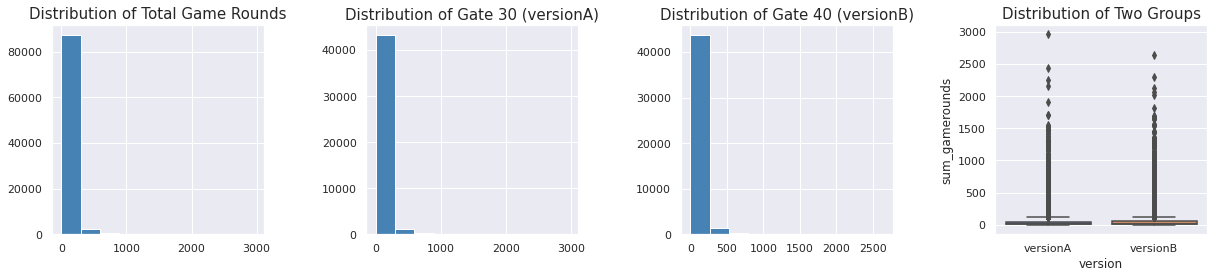

In [22]:
fig, axes = plt.subplots(1, 4, figsize = (18,5))
df.sum_gamerounds.hist(ax = axes[0], color = "steelblue")
df[(df.version == "versionA")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
df[(df.version == "versionB")].hist("sum_gamerounds", ax = axes[2], color = "steelblue")
sns.boxplot(x = df.version, y = df.sum_gamerounds, ax = axes[3])
axes[0].set_title("Distribution of Total Game Rounds", fontsize = 15)
axes[1].set_title("Distribution of Gate 30 (versionA)", fontsize = 15)
axes[2].set_title("Distribution of Gate 40 (versionB)", fontsize = 15)
axes[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

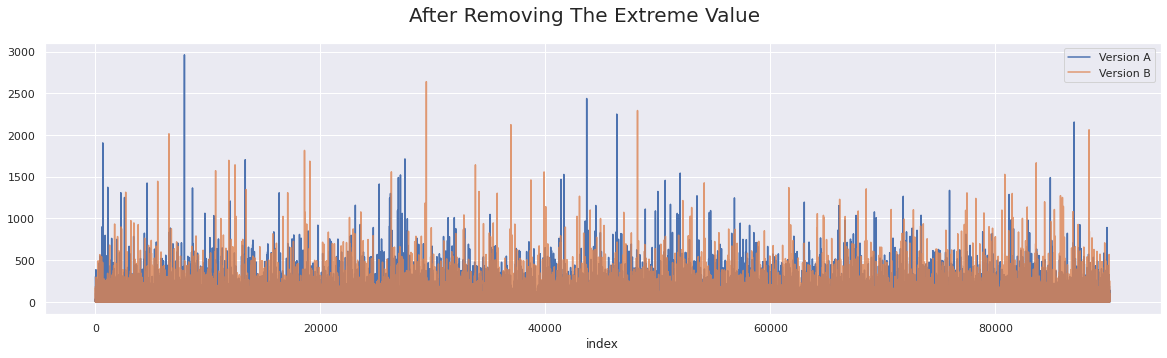

In [23]:
df[(df.version == "versionA")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Version A", figsize = (20,5))
df[df.version == "versionB"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Version B", alpha = 0.8)
plt.suptitle("After Removing The Extreme Value", fontsize = 20);

### Assumptions:
- Check normality
- If Normal Distribution, check homogeneity

### Steps:
- Split & Define Control Group & Test Group
- Apply Shapiro Test for normality
- If parametric apply Levene Test for homogeneity of variances
- If Parametric + homogeneity of variances apply T-Test
- If Parametric - homogeneity of variances apply Welch Test
- If Non-parametric apply Mann Whitney U Test directly

In [24]:
# Split A/B
groupA = df[df['version'] == "versionA"]['sum_gamerounds']
groupB = df[df['version'] == "versionB"]['sum_gamerounds']

In [25]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):
   
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
# Apply A/B Testing

AB_Test(dataframe=df, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.0254,A/B groups are not similar!
